# Assignment 3
## Group 36
## Shridhar Suryanarayan 20949465
## Jitesh Rajamanikyam Udayakumar 20874490



In [ ]:
# connecting google drive
from google.colab import drive, files 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing libraries.

In [ ]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import tensorflow as tf
from tensorflow.keras import datasets,models,layers
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import plotly.express as px

import seaborn as sns
sns.set(style="ticks", color_codes=True)

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True


In [ ]:
# Reading train and test set from the google drive
x_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/x_train.csv', sep=',')
x_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/x_test.csv', sep=',')
y_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/y_train.csv', sep=',')
y_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/y_test.csv', sep=',')

## Notes about the train and test data set

* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.

* Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.

* The training and test data sets each have 785 features which is the pixel-values of the associated image.

##Data Preprocessing

In [ ]:
#Converting pandas series to dataframe
x_train_df = pd.DataFrame(x_train)
x_test_df = pd.DataFrame(x_test)

Plotting one of the random sample from the training set and displaying its gray scale image

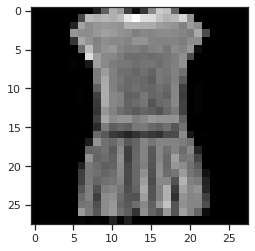

In [ ]:
x_train_plot = x_train_df.values.reshape(60000,28,28)
x_test_plot = x_test_df.values.reshape(10000,28,28)
# pick a sample to plot
sample = 3
image = x_train_plot[sample]

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()


In [ ]:
# Reshaping the training and testing dataset
x_train_images = x_train_df.values.reshape(60000,28,28,1)
x_test_images = x_test_df.values.reshape(10000,28,28,1)

The next step is to normalize the data dimensions so that they are approximately the same scale.

In [ ]:
# Normalizing
x_train_images = x_train_images/255.0
x_test_images = x_test_images/255.0

##CM1

Building the model. 

Firstly, we are using a Sequential model from keras library[1]. The Sequential model is a linear stack of layers.We are adding add all layers at inital stage. The layers added are as follows:

* First layer is Conv2D. Conv2D is a 2D Convolutional layer.

The parameters used are:
  
    1.   Filters - The number of filters (Kernels) used with this layer are 32
    2.   Kernel size - The dimmension of the Kernel is (3 x 3)
    3.   Activation - The activation function used here is Relu
    4.   Input shape - The desired input shape for the model is (28,28,1)
    5.   Stride - The stride of (1,1)
    6.   Padding - There exist padding of 1. 


* Second layer is MaxPooling2D. MaxPooling2D is a Max pooling operation for spatial data. 

The parameters used are:

    1. Pool size used here is (2,2), representing the factors by which to downscale in both directions.

* Third layer is Conv2D again.

The parameters used are:
  
    1.   Filters - The number of filters (Kernels) used with this layer are 32
    2.   Kernel size - The dimmension of the Kernel is (3 x 3)
    3.   Activation - The activation function used here is Relu
    4.   Input shape - The desired input shape for the model is (28,28,1)
    5.   Stride - The stride of (1,1)
    6.   Padding - There exist padding of 1. 


* Next layer is Flatten layer. This layer Flattens the input. Does not affect the batch size. This layer is used without parameters

* Final layer is Dense layer. This layer is a regular fully-connected NN layer. 

The parameters used here are:

    1. Units: The number of classes (5)
    2. Activation : This final layer uses softmax activation 


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),input_shape=(28, 28, 1),padding="same",activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),padding="same",activation="relu"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation='softmax')
])

The model summary table provides a nice visualization of the network architecture and parameters.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dense_8 (Dense)             (None, 5)                 31365     
                                                                 
Total params: 40,933
Trainable params: 40,933
Non-trainable params: 0
__________________________________________________

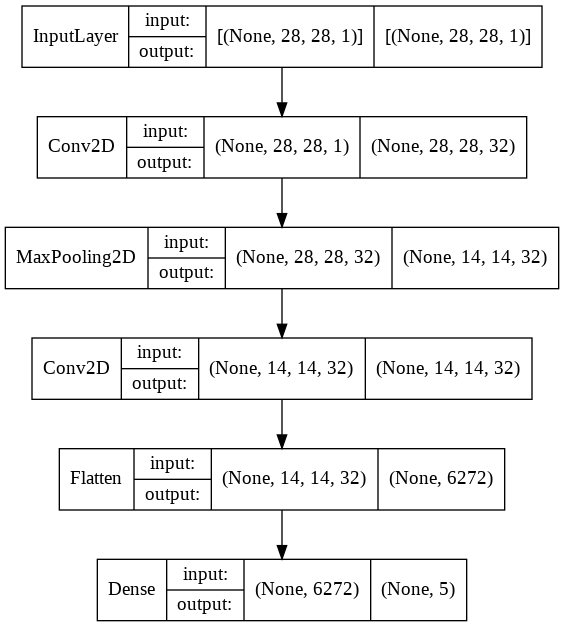

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)


 We compile the model with the following settings:

* Loss function — The loss function calculates the difference between the output and the target variable. It measures the accuracy of the model during training and we want to minimize this function. We have used the *sparse categorical crossentropy* loss function.

* Optimizer — Optimizer tells us how the model is updated and is based on the data and the loss function. *Adam* is an extension to the classic stochastic gradient descent and it is used here because it's proven to be effective and efficient.

* Metrics — Bascially the metrics monitors the training and validation steps. Accuracy is a common metric and it shows the fraction of images that are correctly classified.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Next, we train the model by fitting it to the training data, so we give it the images as input and labels as expected output.

We are trying to minimize overfitting by using the validation split. Here we set the validation_split on the training data to a 90/10 split: 90% for training and 10% for validating.

Training will show you the following results per epoch

During each epoch, the loss decreases and the accuracy increases, meaning our model is improving.

In [ ]:
result = model.fit(x_train_images,y_train,epochs=10,validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 75s 43ms/step - loss: 0.3511 - accuracy: 0.8700 - val_loss: 0.2471 - val_accuracy: 0.9070
Epoch 2/10
1688/1688 [==============================] - 55s 32ms/step - loss: 0.2338 - accuracy: 0.9159 - val_loss: 0.2221 - val_accuracy: 0.9187
Epoch 3/10
1688/1688 [==============================] - 56s 33ms/step - loss: 0.1989 - accuracy: 0.9293 - val_loss: 0.2140 - val_accuracy: 0.9248
Epoch 4/10
1688/1688 [==============================] - 55s 33ms/step - loss: 0.1737 - accuracy: 0.9379 - val_loss: 0.1889 - val_accuracy: 0.9300
Epoch 5/10
1688/1688 [==============================] - 55s 33ms/step - loss: 0.1571 - accuracy: 0.9434 - val_loss: 0.1900 - val_accuracy: 0.9290
Epoch 6/10
1688/1688 [==============================] - 55s 33ms/step - loss: 0.1416 - accuracy: 0.9493 - val_loss: 0.1814 - val_accuracy: 0.9353
Epoch 7/10
1688/1688 [==============================] - 54s 32ms/step - loss: 0.1294 - accuracy: 0.9541 - val_loss: 0.1801 -

We see the training accuracy at end of last epoch is at 96.41% and loss is at 10.24%. Similarly, the validation accuracy is at 93.77% and validation loss is at 18.33%.

We need to evaluate its performance of our model. This is done on a test dataset, new data that the model hasn’t seen yet.

In [ ]:
test_loss, test_acc = model.evaluate(x_test_images, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.1994 - accuracy: 0.9344


With our test dataset, the model is giving accuracy of 93.44% and loss of 19.94%

Text(0.5, 1.0, 'Training vs Validation accuracy')

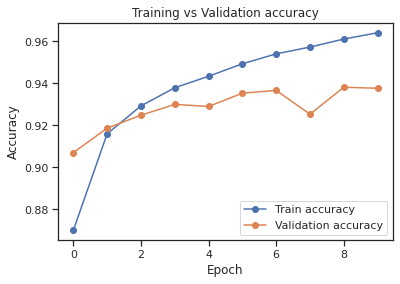

In [ ]:
plt.plot(result.history["accuracy"],label="Train accuracy",marker='o')
plt.plot(result.history["val_accuracy"],label="Validation accuracy",marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title(label="Training vs Validation accuracy")

Text(0.5, 1.0, 'Training vs Validation loss')

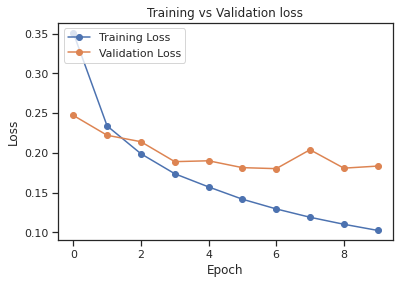

In [ ]:
plt.plot(result.history["loss"],label="Training Loss",marker='o')
plt.plot(result.history["val_loss"],label="Validation Loss",marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.title(label="Training vs Validation loss")

##CM2

Building the model. After trying out various architectures from different refrences **[5,6]**. We have used the model architecture from **[3]**. Which has given us the best results out of all. 

Firstly, we are using a Sequential model from keras library **[1]**. The Sequential model is a linear stack of layers.We are adding add all layers at inital stage. The layers added are as follows:

* First layer is Conv2D. Conv2D is a 2D Convolutional layer.

The parameters used are:
  
    1.   Filters - The number of filters (Kernels) used with this layer are 64
    2.   Kernel size - The dimmension of the Kernel is (3 x 3)
    3.   Activation - The activation function used here is Relu
    4.   Input shape - The desired input shape for the model is (28,28,1)
    5.   Stride - Default
    6.   Padding - No padding
    7.   Kernel initializer - the function used for initializing the kernel.
                              "he_normal" function draws samples from a truncated normal distribution centered on 0 with 
                              stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.

All layers will use the ReLU activation function because it is the best practice.


* Second layer is MaxPooling2D. MaxPooling2D is a Max pooling operation for spatial data. 

The parameters used are:

    1. Pool size used here is (2,2), representing the factors by which to downscale in both directions.

* Third layer is Dropout layer. We have added several Dropout layers to the model, to help avoiding overfitting. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged **[2]**.

The parameters used are:

    1. Rate used here is 0.25 [3]

* Fourth layer is Conv2D again.

The parameters used are:
  
    1.   Filters - The number of filters (Kernels) used with this layer are 128
    2.   Kernel size - The dimmension of the Kernel is (3 x 3)
    3.   Activation - The activation function used here is Relu
    4.   Input shape - The desired input shape for the model is (28,28,1)
    5.   Stride - Default
    6.   Padding - No padding

* Fifth layer is MaxPooling2D.

The parameters used are:

    1. Pool size used here is (2,2).

* Sixth layer is Dropout layer.

The parameters used are:

    1. Rate used here is 0.25.

* Seventh layer is Conv2D.

The parameters used are:
  
    1.   Filters - The number of filters (Kernels) used with this layer are 128
    2.   Kernel size - The dimmension of the Kernel is (3 x 3)
    3.   Activation - The activation function used here is Relu
    4.   Input shape - The desired input shape for the model is (28,28,1)
    5.   Stride - Default
    6.   Padding - No padding

* Next layer is Dropout layer.

The parameters used are:

    1. Rate used here is 0.4.


Next layer is.

* Next layer is Flatten layer. This layer Flattens the input. Does not affect the batch size. This layer is used without parameters

Furthermore, there is Dense layer. This layer is a regular fully-connected NN layer.
The parameters used are:

    1. Units - A positive integer, which represents dimensionality of the output space, in our model it is 128.
    2. activation function : relu

* Next layer is Dropout layer.

The parameters used are:

    1. Rate used here is 0.33.


* Final layer is Dense layer. This layer is a regular fully-connected NN layer. 

The parameters used here are:

    1. Units: The number of classes (5)
    2. Activation : This final layer uses softmax activation 


 We compile the model with the following settings **[3]**:

* Loss function — The loss function calculates the difference between the output and the target variable. It measures the accuracy of the model during training and we want to minimize this function. We have used the *sparse categorical crossentropy* loss function. We have used sparse categorical cross entropy because it saves time in memory as well as computation because it simply uses a single integer for a class, rather than a whole vector.



* Optimizer — Optimizer tells us how the model is updated and is based on the data and the loss function. *Adam* is an extension to the classic stochastic gradient descent and it is used here because it's proven to be effective and efficient.

* Metrics — Bascially the metrics monitors the training and validation steps. Accuracy is a common metric and it shows the fraction of images that are correctly classified.

In [ ]:
model_6 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3),input_shape=(28, 28, 1),padding="valid",activation="relu",kernel_initializer='he_normal'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64,(3,3),padding="valid",activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(128,(3,3),padding="valid",activation="relu"),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.33),
  tf.keras.layers.Dense(5, activation='softmax')
])
model_6.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

The model summary table provides a nice visualization of the network architecture and parameters.

In [ ]:
model_6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 5, 5, 64)         

In [ ]:
tf.keras.utils.plot_model(model_6, to_file='model_6.png', show_shapes=True, show_layer_names=True)

Next, we train the model by fitting it to the training data, so we give it the images as input and labels as expected output.

We are trying to minimize overfitting by using the validation split. Here we set the validation_split on the training data to a 80/20 split: 80% for training and 20% for validating.

Training will show you the following results per epoch

During each epoch, the loss decreases and the accuracy increases, meaning our model is improving.

In [ ]:
start = time.time()
result_6 = model_6.fit(x_train_images,y_train,epochs=10,validation_split=0.2)
print("Total training time: ", time.time() - start, "seconds")

Epoch 1/10
1500/1500 [==============================] - 73s 47ms/step - loss: 0.4979 - accuracy: 0.8020 - val_loss: 0.3033 - val_accuracy: 0.8865
Epoch 2/10
1500/1500 [==============================] - 66s 44ms/step - loss: 0.3231 - accuracy: 0.8804 - val_loss: 0.2475 - val_accuracy: 0.9080
Epoch 3/10
1500/1500 [==============================] - 59s 39ms/step - loss: 0.2789 - accuracy: 0.8976 - val_loss: 0.2196 - val_accuracy: 0.9172
Epoch 4/10
1500/1500 [==============================] - 60s 40ms/step - loss: 0.2535 - accuracy: 0.9081 - val_loss: 0.2084 - val_accuracy: 0.9243
Epoch 5/10
1500/1500 [==============================] - 65s 44ms/step - loss: 0.2406 - accuracy: 0.9121 - val_loss: 0.1987 - val_accuracy: 0.9271
Epoch 6/10
1500/1500 [==============================] - 68s 45ms/step - loss: 0.2285 - accuracy: 0.9172 - val_loss: 0.2005 - val_accuracy: 0.9274
Epoch 7/10
1500/1500 [==============================] - 68s 46ms/step - loss: 0.2194 - accuracy: 0.9202 - val_loss: 0.1893 -

We see the training accuracy at end of last epoch is at 92.65% and loss is at 20.39%. Similarly, the validation accuracy is at 93.16% and validation loss is at 18.48%.

We need to evaluate its performance of our model. This is done on a test dataset, new data that the model hasn’t seen yet.

In [ ]:
start = time.time()
test_loss_6, test_acc_6 = model_6.evaluate(x_test_images, y_test)
print("Total test time: ", time.time() - start, "seconds")

313/313 [==============================] - 4s 12ms/step - loss: 0.1931 - accuracy: 0.9298
Total test time:  3.97511887550354 seconds


With our test dataset, the model is giving accuracy of 92.98% and loss of 19.31%



---



---



## CM3

* The runtime performace to train the model is around 683 seconds.
* In contrast the runtime during the model evaluation is 3.97 seconds. 

I have tried different architectures in the model with other references **[5,6]**. Fully connected Neural networks architecture as well as Convolutional Neural Networks each with different number of layers.

Some of the other parameters that were tried are:

    1. Conv2d layer with padding and strides. 
       Different number of filters in different Conv2d layers and different activation function.
    2. Loss funtions with categorical crossentropy.
    3. Rmsprop as the optimizer

Some of the problems that arised during other architecture implementations were:

    1. Although fully connected networks make no assumptions about the input they tend to perform less and aren’t good for feature extraction.
    2. They have a higher number of weights to train that results in high training time while on the other hand CNNs are trained to identify and 
       extract the best features from the images for the problem at hand with relatively fewer parameters to train.
    3. Also compared to the CNN, the total number of parameters is relatively more in fully connected neural network model. 
    4. But in some of the CNN's the validation accuracy does not improve after few epochs and the validation loss is increasing after few epochs. 
       This confirmed that the model is overfitted.

After adding the Dropout layers to our current model, the validation accuracy and validation loss are much better.



---



Text(0.5, 1.0, 'Training vs Validation loss')

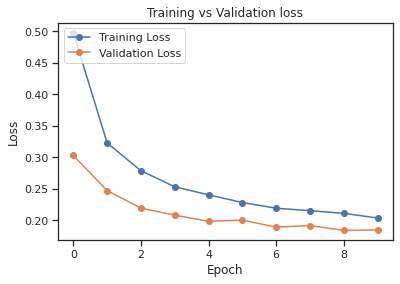

In [ ]:
plt.plot(result_6.history["loss"],label="Training Loss",marker='o')
plt.plot(result_6.history["val_loss"],label="Validation Loss",marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.title("Training vs Validation loss")

Text(0.5, 1.0, 'Training vs Validation Accuracy')

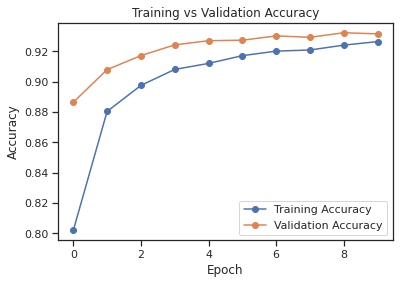

In [ ]:
plt.plot(result_6.history["accuracy"],label="Training Accuracy",marker='o')
plt.plot(result_6.history["val_accuracy"],label="Validation Accuracy",marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title("Training vs Validation Accuracy")

* Although we still see some overfitting in the graphs, but we observe that the convolutional neural network performs better than the fully connected neural networks that was tried earlier, achieving a training accuracy of 92.65% and a test accuracy of 92.98%, and a test loss of about 19%. 


 * We can reduced overfitting by reducing the number of neurons from the previously tried model from 512, as well as adding the dropout layers.
 The rate in the Dropout layer is the percentage of connections between layers that are being removed. 
 
 * After adding the Dropout layers, the validation accuracy and validation loss are much better than the previous tried model.

#CM4

We get the feature encodings from a last but one fully connected layer called "dense_4" using the keras library Model function **[7]**

In [ ]:
layer_name = 'dense_11'
intermediate_layer_model = Model(inputs=model_6.input,
                                 outputs=model_6.get_layer(layer_name).output)

After defining intermediate layer, the fuction returns a Functional API to which we give a the test images to get the features. This returns a tensor of size 128 which was the dimension of our fully connected layer input to the function

In [ ]:
intermediate_output = intermediate_layer_model(x_test_images)

### PCA on the intermediate layer encoding

Furthermore, we have used *Principle component analysis (PCA)* for dimensionality reduction. The 128 feature space is now reduced to 2 dimensions and its easier to plot our data.

The advantage of PCA is that it compresses your data down to something that is more effectively modeled. This means that it will compress away highly correlated and colinear variables. **[8]**

We have defined a new dataframe "principleDf" consisting of two principle components for plotting.

In [ ]:
pca = PCA(n_components=2,random_state=9)
intermediate_output_pca = pca.fit_transform(intermediate_output)

In [ ]:
principalDf = pd.DataFrame(data= intermediate_output_pca,
                           columns = ['Principal Component 1', 'Principal Component 2'])

In [ ]:
#For mapping the labels
def catger(rr):
    if rr == 0  : return '0'
    elif rr == 1: return '1'
    elif rr == 2: return '2'
    elif rr == 3: return '3'
    elif rr == 4: return '4'   
    else: return 'None'

In [ ]:
# Converting the test labels into series mapping it to a catger function for diffrent colors
y_test_ser = y_test['0']
y_mapped = y_test_ser.map(catger)


[Text(0.5, 1.0, 'PCA with true lables')]

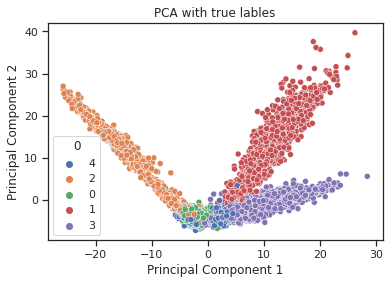

In [ ]:
sns.scatterplot(data=principalDf, x='Principal Component 1', y='Principal Component 2', hue=y_mapped, palette="deep").set(title="PCA with true lables")
# Figure shows PC1 and PC2 with different labels as color

* This plot shows us the 2 principle components from the encoding of our cnn model. Classes 2,3,4 seem to have more variance than the classes 1,2.

* The principal components are constructed in such a manner that the first principal component accounts for the largest possible variance in the data set

* The second principal component is calculated in the same way, with the condition that it is uncorrelated with (i.e., perpendicular to) the first principal component and that it accounts for the next highest variance.

### DBSCAN on intermediate layer encoding 

* DBSCAN is a density-based clustering algorithm that works on the assumption that clusters are dense regions in space separated by regions of lower density.

* It groups ‘densely grouped’ data points into a single cluster.

#### Advantages of using DBSCAN is: [8]

* DBSCAN clustering is robust to outliers.

* It also does not require the number of clusters to be told beforehand, unlike K-Means, where we have to specify the number of centroids, which is accutally an advantage.

Parametes used to get the clusters are:

      1. Epsilon: 5 (Radius of the circle to be created around each data point to check the density). 

      2. MinPoints: 47 (It is the minimum number of data points required inside that circle).

We apply DBSCAN algorithm on intermediate layer encoding. And we use clusering lables from the DBSCAN as the hue for the graph.



In [ ]:
clustering = DBSCAN(eps=5, min_samples=57).fit(intermediate_output)
cluster = clustering.labels_
len(set(cluster))

6

Note: By using trail and error method we have come down to 6 clusters. 0-4 represents classes and -1 represents noise.

In [ ]:
(unique, counts) = np.unique(cluster, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  -1, 2729],
       [   0,  895],
       [   1, 5657],
       [   2,  198],
       [   3,  439],
       [   4,   82]])

We here see counts of points that are available in each of the cluster. We can notice that noise has too many points in its cluster. It means that the accuracy of the clustering using this algorithm is fairly low. 

[Text(0.5, 1.0, 'PCA with DBSCAN cluster')]

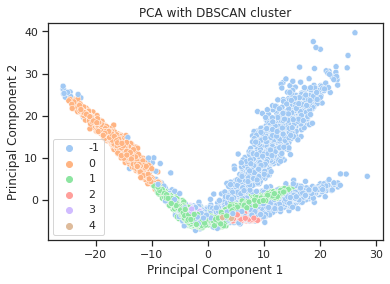

In [ ]:
sns.scatterplot(data=principalDf, x='Principal Component 1', y='Principal Component 2', hue=cluster, palette="pastel").set(title="PCA with DBSCAN cluster")
# Figure shows PC1 and PC2 with different labels as color

We can see that classes 3 and 4 has relatively less clusters in the plot as compared to classes 0,1,2.  

### K-Means on the intermediate encoding

* The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It uses a simple optimal clustering technique. It uses unsupervised learning.

* The parameters we are using here are just predetermined number of clusters and random state.

* Its important to note that, slight variations in the data could lead to high variance which makes kmeans not as effective sometimes.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(intermediate_output)


In [ ]:
## Accuracy score for K Means.
from sklearn.metrics import accuracy_score
cluster_labels = kmeans.predict(intermediate_output)
print(accuracy_score(y_test, cluster_labels))

0.3918


The accuracy score for random prediction is 20%. But kmeans is giving a relatively higher accuracy

In [ ]:
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 1619],
       [   1,  866],
       [   2,  901],
       [   3,  857],
       [   4, 5757]])

In [ ]:
 kmeansCluster = kmeans.labels_


[Text(0.5, 1.0, 'PCA with K-means cluster')]

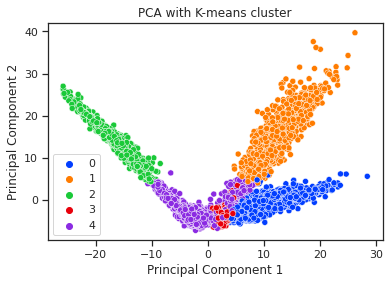

In [ ]:
sns.scatterplot(data=principalDf, x='Principal Component 1', y='Principal Component 2', hue=kmeansCluster, palette="bright").set(title="PCA with K-means cluster")
# Figure shows PC1 and PC2 with different labels as color


We can see that class 0 has very high number of classed than any other classes. But we can also see relatively less variance than DBSCAN.  

### t-SNE algorith with intermediate encoding

* t-SNE like PCA, is used to represent the higher dimension to low dimension

* However, t-SNE differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance **[10]**.

* It is important to note that t-SNE is not a clustering approach since it does not preserve the inputs like PCA and the values may often change between runs so it’s purely for exploration.

The parameters used here are:
      
      1. n_components: 2 (Number of components)
      2. Learning rate: "auto". The ‘auto’ option sets the learning_rate to max(N / early_exaggeration / 4, 50) **[11]**
      3. init: "random"  

We give the intermediate layer encoding with 128 features to tSNE.

In [ ]:
intermediate_output_tsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(intermediate_output)

In [ ]:
tsneDf = pd.DataFrame(data= intermediate_output_tsne,
                           columns = ['TSNE Component 1', 'TSNE Component 2'])

Visualizing tSNE components with true labels 

[Text(0.5, 1.0, 'tSNE with true labels')]

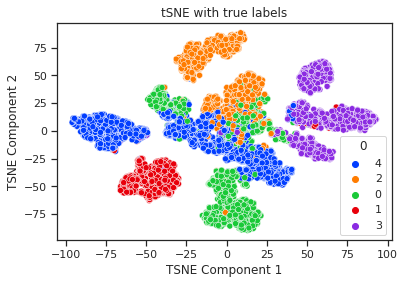

In [ ]:
sns.scatterplot(data=tsneDf, x='TSNE Component 1', y='TSNE Component 2', hue=y_mapped, palette="bright").set(title="tSNE with true labels")



Visualizing tSNE components with kmeans cluster labels. 

[Text(0.5, 1.0, 'tSNE with K-means cluster')]

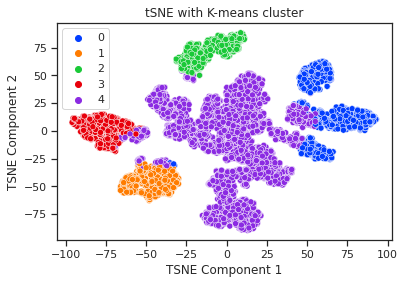

In [ ]:
sns.scatterplot(data=tsneDf, x='TSNE Component 1', y='TSNE Component 2', hue=kmeansCluster, palette="bright").set(title="tSNE with K-means cluster")



We can see that while using true lables for tSNE, there is fair amount of error in the components in the plot. But the tSNE with the kmeans cluseter is relatively low, but theres is still a good error percentage. So this tSNE polt cannot be used for guessing the lables of the data set.

In [ ]:
num_row = 6
num_col = 14
num = num_row*num_col
images = x_test_plot[:num]
labels = cluster_labels[:num]
tr_labels = y_test['0'].to_numpy()[:num]

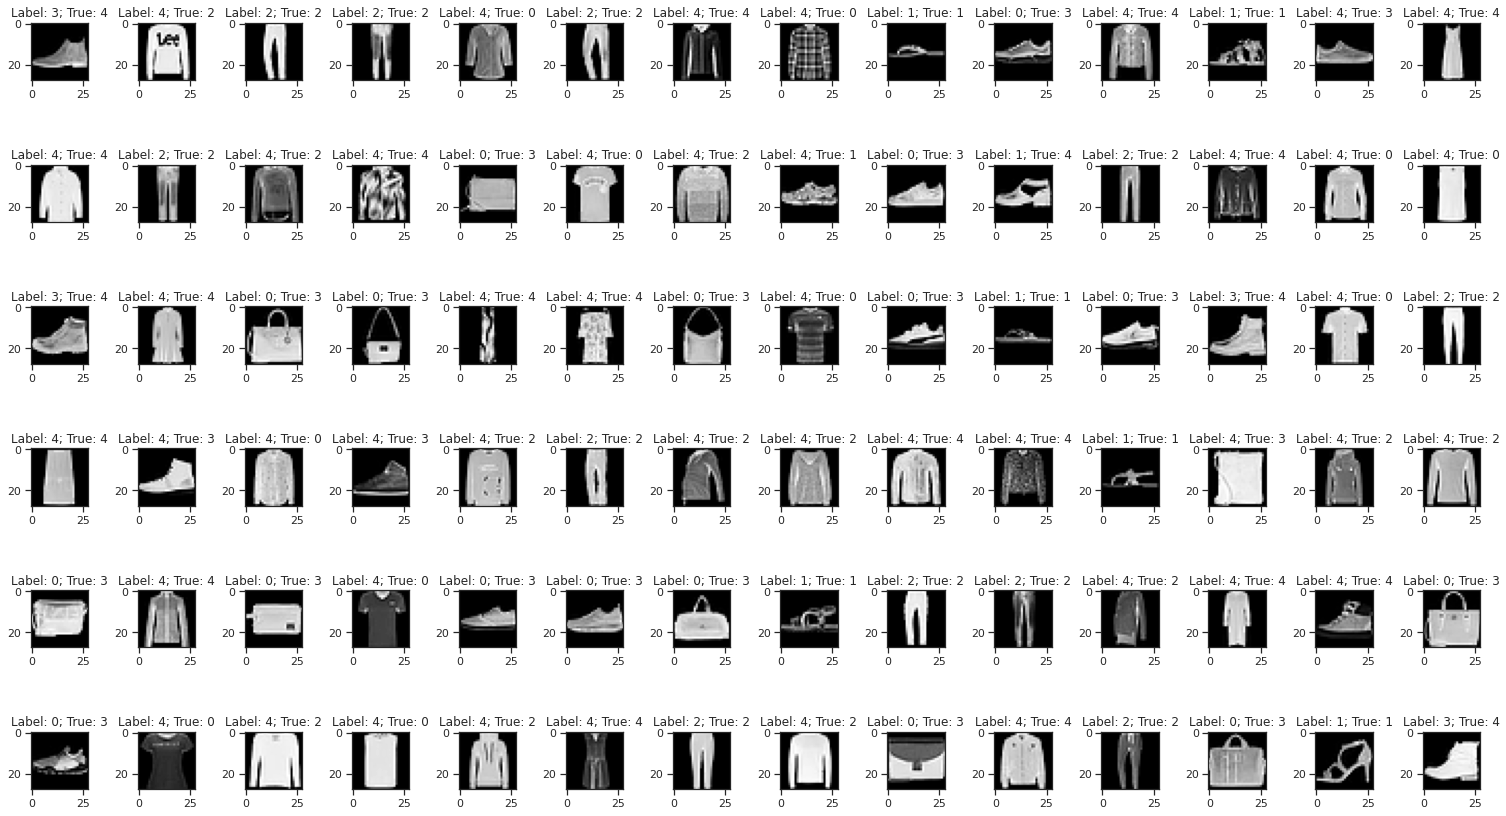

In [ ]:
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}; True: {}'.format(labels[i], tr_labels[i]))
plt.tight_layout()
plt.show()

By seeing the images above we can make a fair guess the names of the mystery labels 

Classes: 

    Class 0: Shirts and Tshirts
    Class 1: Pants and Trouser
    Class 2: Sandals
    Class 3: Bags
    Class 4: Boots and Sneakers

References:

    [1] Sequential Models - https://keras.io/guides/sequential_model/

    [2] Droput layers - https://keras.io/api/layers/regularization_layers/dropout/

    [3] Tensorflow implementation - https://www.kaggle.com/code/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist/notebook

    [4] Loss function - https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other

    [5] DNN - https://medium.com/swlh/fully-connected-vs-convolutional-neural-networks-813ca7bc6ee5

    [6] CNN model - https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

    [7] Intermediate layer - https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

    [8] PCA - https://www.kaggle.com/code/residentmario/dimensionality-reduction-and-pca-for-fashion-mnist/notebook

    [9] DBSCAN - https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/#:~:text=DBSCAN%20is%20a%20density%2Dbased,points%20into%20a%20single%20cluster.

    [10] tSNE - https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1

    [11] tSNE - https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html